In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
import datetime

    IMPORT THE DATA: CONCATENATE ALL 18 FILES IN ONE DATAFRAME df

rename restaurnats ids in 1,2,...,18 for easier readabilty of the graphs

In [4]:
import glob

path = r'/Users/ivanapetrovic/Downloads/18_restaurants_2018' 
all_files = glob.glob(path + "/*.csv")

In [5]:
list_files = []
store_id=0

for filename in all_files:
    store_id += 1 
    df_tmp = pd.read_csv(filename, index_col=None, names=['store_id', 'ticket_id', 'ticket_open_time', 'ticket_close_time', 'ticket_guest_count', 'business_date', 'ticket_tax', 'ticket_tip', 'ticket_net_sales', 'item_category', 'item_subcategory', 'item_name','item_id', 'item_sales','item_quantity', 'unit_price'])
    df_tmp['store_id']=store_id  
    list_files.append(df_tmp)

In [6]:
df = pd.concat(list_files, ignore_index=True)

In [113]:
df.shape

(3575063, 16)

Convert dates to datetime 

In [9]:
df['ticket_open_time'] = pd.to_datetime(df['ticket_open_time'],infer_datetime_format=True)
df['ticket_close_time'] = pd.to_datetime(df['ticket_close_time'],infer_datetime_format=True)
df['business_date'] = pd.to_datetime(df['business_date'],infer_datetime_format=True)

EXPLORING MISSING DATA AND CHECKING WHETHER THE DATA THAT WE SEE MAKES SENSE

In [10]:
df.isna().sum()  # number of missing data per column

store_id                   0
ticket_id                  0
ticket_open_time           0
ticket_close_time        382
ticket_guest_count         0
business_date              0
ticket_tax                 0
ticket_tip                 0
ticket_net_sales           0
item_category            311
item_subcategory      145985
item_name                196
item_id                    0
item_sales                 0
item_quantity              0
unit_price                 0
dtype: int64

Depending on the question that we care about, we might need to consider how to take care of these missing values.
<JC: nice touch looking for missing data>

In [11]:
df['ticket_net_sales'].describe()   

count    3.575063e+06
mean     7.113580e+01
std      1.780968e+02
min     -2.246290e+03
25%      2.199000e+01
50%      4.223000e+01
75%      7.597000e+01
max      5.034801e+04
Name: ticket_net_sales, dtype: float64

In [12]:
len(df[df['ticket_net_sales']<0].groupby('ticket_id')) # number of tickets with negative sales

2488

Some ticket net sales <0 . These are probably voids... to confirm.
<JC: very astute observation>

In [13]:
len(df[df['ticket_net_sales']==0].groupby('ticket_id')) # number of tickets with zero sales

25317

Some ticket have sale zero...Have to explore whether these are due to some employee discount for example or if these 
are not entered by mistake, in which case we might want to impute the zero values 

In [14]:
df[df['ticket_guest_count']==0].shape[0] #total number of rows missing guests' count

1439303

In [15]:
len(df[df['ticket_guest_count']==0].groupby('ticket_id')) #total number of tickets missing guests' count

467532

Zero guests on a ticket is most probably an omission in entering the data. In further analysis, we may want to impute zero values in guests' count.

In [17]:
len(df[(df['ticket_guest_count']==0) & (df['ticket_net_sales']==0)].groupby('ticket_id')) #total number of tickets missing guests' count and having total sales =0 

11739

In [18]:
df['unit_price'].describe()

count    3.575063e+06
mean     7.996002e+00
std      2.936023e+01
min     -1.250000e+02
25%      3.470000e+00
50%      6.000000e+00
75%      1.000000e+01
max      5.034801e+04
Name: unit_price, dtype: float64

In [19]:
len(df[df['unit_price']<0].groupby('item_id')) # number of items with negative price

25

In [20]:
len(df[df['unit_price']==0].groupby('item_id')) # number of items with price zero

1483

In [21]:
len(df[(df['unit_price']==0) & (df['item_quantity']>0)].groupby('item_id')) # number of items with price zero, where quantity purchased >0 

788

In [22]:
df['item_quantity'].describe()

count    3.575063e+06
mean     1.053661e+00
std      8.712868e-01
min     -1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      6.660000e+02
Name: item_quantity, dtype: float64

In [23]:
df[df['item_quantity'].round() !=df['item_quantity']]['item_quantity'].unique()  #what do these values mean??

array([0.5 , 0.33, 0.34, 0.2 , 0.25, 0.17, 0.16, 0.14, 0.15, 0.13, 0.12,
       1.5 , 0.11, 0.67, 0.66, 1.2 ])

In [24]:
df[df['item_quantity'].round() !=df['item_quantity']]['item_quantity'].count()

8139

In [25]:
df[(df['store_id']==1) & (df['ticket_id']==1846708111)].head()

,store_id,ticket_id,ticket_open_time,ticket_close_time,ticket_guest_count,business_date,ticket_tax,ticket_tip,ticket_net_sales,item_category,item_subcategory,item_name,item_id,item_sales,item_quantity,unit_price
249,1,1846708111,2018-01-01 23:29:27,2018-01-02 00:07:53,0,2018-01-01,2.24,0.0,28.0,Food,Salads,No Boundaries,201374,7.5,1.0,7.5
250,1,1846708111,2018-01-01 23:29:27,2018-01-02 00:07:53,0,2018-01-01,2.24,0.0,28.0,Food,Salads,No Boundaries,201374,7.5,1.0,7.5
251,1,1846708111,2018-01-01 23:29:27,2018-01-02 00:07:53,0,2018-01-01,2.24,0.0,28.0,Food,Salads,No Boundaries,201374,7.5,1.0,7.5
252,1,1846708111,2018-01-01 23:29:27,2018-01-02 00:07:53,0,2018-01-01,2.24,0.0,28.0,Food,Food Preps,Add Chicken $,202163,2.5,1.0,2.5
253,1,1846708111,2018-01-01 23:29:27,2018-01-02 00:07:53,0,2018-01-01,2.24,0.0,28.0,Food,Food Preps,Add Chicken $,202163,2.5,1.0,2.5


Note that first three rows are identical - how can we know that this is not an error?

DATA AGGREGATIONS

In [27]:
# total sales per restaurant in 2018, not including tax, tips, discounts and voids
s=[];
store_id=0;
for filename in all_files:
    store_id += 1
    s.append(df[df['store_id']==store_id].groupby('ticket_id')['ticket_net_sales'].mean().sum().round())

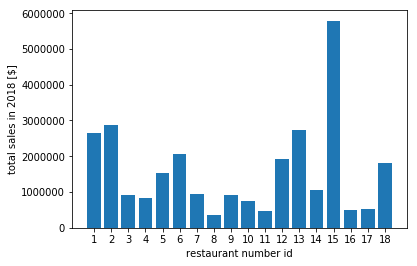

In [29]:
plt.bar(np.arange(len(all_files)), s)
plt.xticks(np.arange(len(all_files)), np.arange(1,19))
plt.xlabel("restaurant number id")
plt.ylabel("total sales in 2018 [$]")
plt.show()
# FOR EASIER READABILITY, MAYBE CHANGE Y-AXIS SCALE

FOOD VS DRINKS SALES

Let's compare sales of food vs drinks in all of the restaurants. In order to do that we have to classify item categories in three groups: food, drinks and other

In [30]:
df['item_category'].unique()  # see all existing item categories

array(['Flatbreads', 'N/A Bev', 'Beer', 'Food', 'Liquor', 'Wine',
       'Retail', 'Bowling', 'BEER', 'Creamery', 'Fees', 'RETAIL',
       'Beverage', 'Gift Cards', 'Miscellaneous', 'Kids', 'New Years',
       'Curry', 'FOOD', 'N/A BEVERAGES', 'Spirits', 'Cocktails',
       'Specials', 'Rental', 'Retail Beers', 'Merchandise',
       'Employee Price List', 'Cooking classes', 'Room Deposit',
       'Beverages', 'Gift Card', 'Breakfast Sides', 'Breakfast', 'Bakery',
       'Lunch', 'Soups & Salads', 'Grab n Go', 'Breakfast special',
       'Breakfast Sandwiches', 'Dinner', 'Non Alcoholic Beverages',
       'Misc.', 'Gift Certificate', 'LIQUOR', 'SPECIALS', 'WINE', 'PIZZA',
       'ENTREES', 'SOUP/SALADS', 'SANDW/BURGERS', 'BEVERAGES',
       'APPETIZERS', 'CHILDRENS', 'SIDES', 'DESSERTS',
       'PROMOTION/DISCOUNTS', 'MISC CHARGES', nan, 'FUNCTIONS',
       'SANDWICHES', 'FOOD OPTIONS', 'KIDS', 'SOUP/SALADS/APPS',
       'FOOD OPTIONS CONT.', 'LIQUOR OPTIONS', 'DRAFT BEER',
       'BOTTL

In [31]:
List_drinks=['N/A Bev','Beer', 'Liquor', 'Wine','BEER', 'Beverage','N/A BEVERAGES', 'Spirits', 'Cocktails','Retail Beers','Beverages','Non Alcoholic Beverages', 'LIQUOR', 'WINE','BEVERAGES', 'LIQUOR OPTIONS', 'DRAFT BEER', 'BOTTLE BEER', 'FUNCTIONS']

In [32]:
List_food=['Flatbreads','Food','Creamery', 'Kids', 'New Years','Curry', 'FOOD','Specials','Breakfast Sides', 'Breakfast', 'Bakery','Lunch', 'Soups & Salads', 'Grab n Go', 'Breakfast special','Breakfast Sandwiches', 'Dinner', 'SPECIALS', 'PIZZA','ENTREES', 'SOUP/SALADS', 'SANDW/BURGERS','APPETIZERS', 'CHILDRENS', 'SIDES', 'DESSERTS','SANDWICHES', 'FOOD OPTIONS', 'KIDS', 'SOUP/SALADS/APPS','FOOD OPTIONS CONT.','PIZZA / CALZONE','Launch','ENTREE', 'APPETIZER', 'DESSERT']

In [33]:
List_other= ['Retail','Bowling', 'Fees','RETAIL','Gift Cards', 'Miscellaneous', 'Rental','Merchandise','Employee Price List','Cooking classes', 'Room Deposit','Gift Card','Misc.', 'Gift Certificate','PROMOTION/DISCOUNTS', 'MISC CHARGES', 'DISCOUNT/PROMOS', 'MISC','Clothes', 'Member Dockage', 'Nonmember Dockage','Lift','Member Electric','Nonmember Electric', 'Boat Charges']

In [34]:
# total sales per restaurant in 2018, not including tax, tips, discounts and voids
s_items=[];
store_id=0;
for filename in all_files:
    store_id += 1
    s_items.append(df[df['store_id']==store_id].groupby('ticket_id')['item_sales'].sum().sum().round())

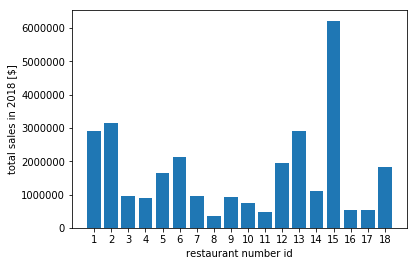

In [35]:
plt.bar(np.arange(len(all_files)), s_items)
plt.xticks(np.arange(len(all_files)), np.arange(1,19))
plt.xlabel("restaurant number id")
plt.ylabel("total sales in 2018 [$]")
plt.show()

Don't understand why total sales calculated as sums of ticket sales differ from total item cost (is it just tax/promotions/...)?

In [36]:
# total sales of food vs drinks at the restaurants in 2018, not including tax, tips, discounts and voids
s_items_drinks=[];
s_items_food=[];
store_id=0;
for filename in all_files:
    store_id += 1
    s_items_drinks.append(df[(df['store_id']==store_id) & (df['item_category'].isin(List_drinks))].groupby('ticket_id')['item_sales'].sum().sum().round())
    s_items_food.append(df[(df['store_id']==store_id) & (df['item_category'].isin(List_food))].groupby('ticket_id')['item_sales'].sum().sum().round())
                   

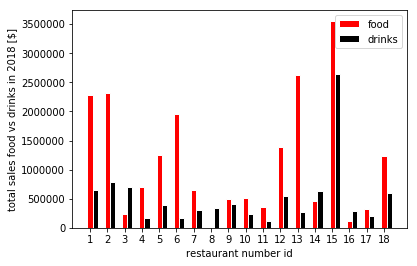

In [37]:
barWidth=0.3
r1 = np.arange(len(all_files))
r2 = [x + barWidth for x in r1]
plt.bar(r1, s_items_food, color='red', width=barWidth, edgecolor='white', label='food')
plt.bar(r2, s_items_drinks, color='black', width=barWidth, edgecolor='white', label='drinks')
plt.xticks(np.arange(len(all_files)), np.arange(1,19))
plt.xlabel("restaurant number id")
plt.ylabel("total sales food vs drinks in 2018 [$]")
plt.legend()
plt.show()

can conclude that restaurant #8 is a bar serving only drinks and that #3 is also specilized in drinks 

DAILY SALES TIMESERIES

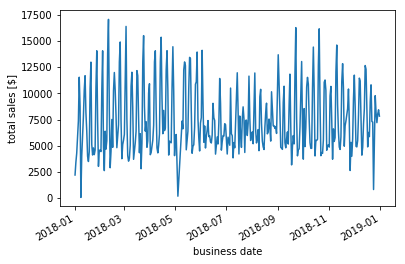

In [38]:
#Restaurant #1
store_id=1
daily_sales=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()
daily_sales.plot(legend=False)
#df[df['store_id']==1].groupby('business_date')['item_sales'].sum().plot()
plt.xlabel('business date')
plt.ylabel('total sales [$]')
plt.show()

In [39]:
#Day of the year with the smallest sale: date, total amount of sales, and day of the week
print(daily_sales.idxmin())
print(daily_sales.min())
import calendar
calendar.day_name[daily_sales.idxmin()['ticket_net_sales'].weekday()]

ticket_net_sales   2018-01-08
dtype: datetime64[ns]
ticket_net_sales    60.75
dtype: float64


'Monday'

In [40]:
#Day of the year with the largest sale: date, total amount of sales, and day of the week
print(daily_sales.idxmax())
print(daily_sales.max())
import calendar
calendar.day_name[daily_sales.idxmax()['ticket_net_sales'].weekday()]

ticket_net_sales   2018-02-10
dtype: datetime64[ns]
ticket_net_sales    17071.11
dtype: float64


'Saturday'

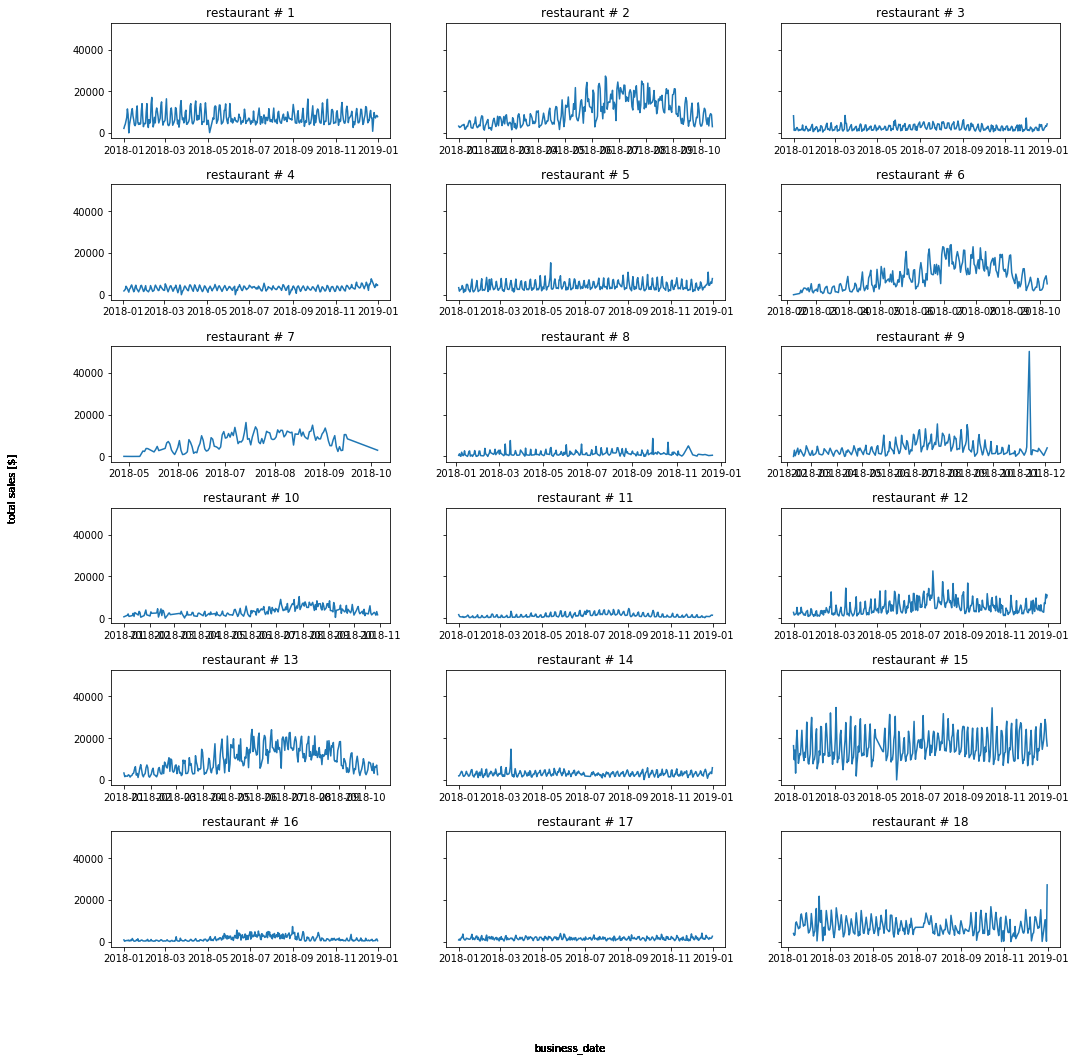

In [41]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(nrows=6, ncols=3, sharey=True, figsize=(17,17) )
fig.subplots_adjust(hspace=0.4)
store_id=0
for row in ax:
    for col in row:
        store_id += 1
        daily_sales=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()
        col.plot(daily_sales)
        col.set_title('restaurant # %i' %store_id)
        fig.text(0.5, 0.04, 'business_date', ha='center')
        fig.text(0.04, 0.5, 'total sales [$]', va='center', rotation='vertical')
plt.show()

# SHOULD IMPROVE VISUALIZATION, AT LEAST BY SHORTENING DATE FORMATS TO JAN, FEB, MAR, etc!! AND SAME Y AXIS


Restaurant 14 is a bit particular because of one single big peak. Let's see what day it happened

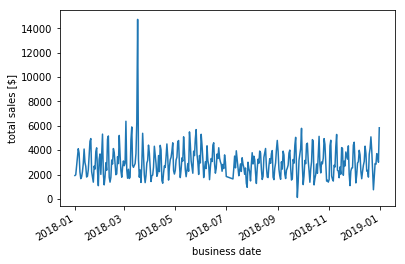

ticket_net_sales   2018-03-17
dtype: datetime64[ns]
ticket_net_sales    14732.8
dtype: float64


'Saturday'

In [42]:
store_id=14
daily_sales=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()
daily_sales.plot(legend=False)
#df[df['store_id']==1].groupby('business_date')['item_sales'].sum().plot()
plt.xlabel('business date')
plt.ylabel('total sales [$]')
plt.show()
print(daily_sales.idxmax())
print(daily_sales.max())
import calendar
calendar.day_name[daily_sales.idxmax()['ticket_net_sales'].weekday()]


Note: it's Saturday 2018-03-17 which, after checking Google, turns out to be St Patrick's day!

HEAT MAPS AS A FUNCTIONS OF DAY OF THE WEEK AND MONTH TO SEE TRENDS

In [43]:
heatmap = np.zeros((7, 12))
qmap = np.zeros((7, 12))  
#heatmap[:] = np.nan

store_id=1
daily_sales=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()

for ind in range(0,len(daily_sales.index)):
    day=daily_sales.index[ind].dayofweek
    month=daily_sales.index[ind].month
    qmap[day, month-1] += 1
    heatmap[day, month-1] = heatmap[day, month-1]+daily_sales['ticket_net_sales'][ind]  

heatmap = np.divide(heatmap,qmap)

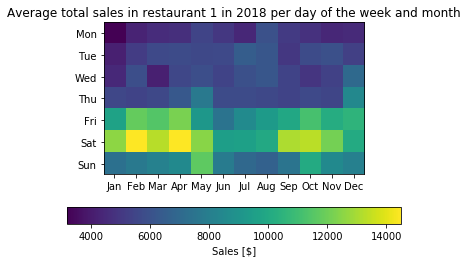

In [44]:
fig = plt.figure()
ax = fig.add_subplot(111)
im = ax.imshow(heatmap, interpolation='nearest')
ax.set_title('Average total sales in restaurant 1 in 2018 per day of the week and month')
ax.set_yticks(range(7))
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'])
ax.set_xticks(range(12))
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
cbar = fig.colorbar(ax=ax, mappable=im, orientation='horizontal')
cbar.set_label('Sales [$]')

Expected pattern of slower turnover during beginning of the week (and beginning of the year), faster turnover on Fridays and Saturdays.

NUMBER OF GUESTS

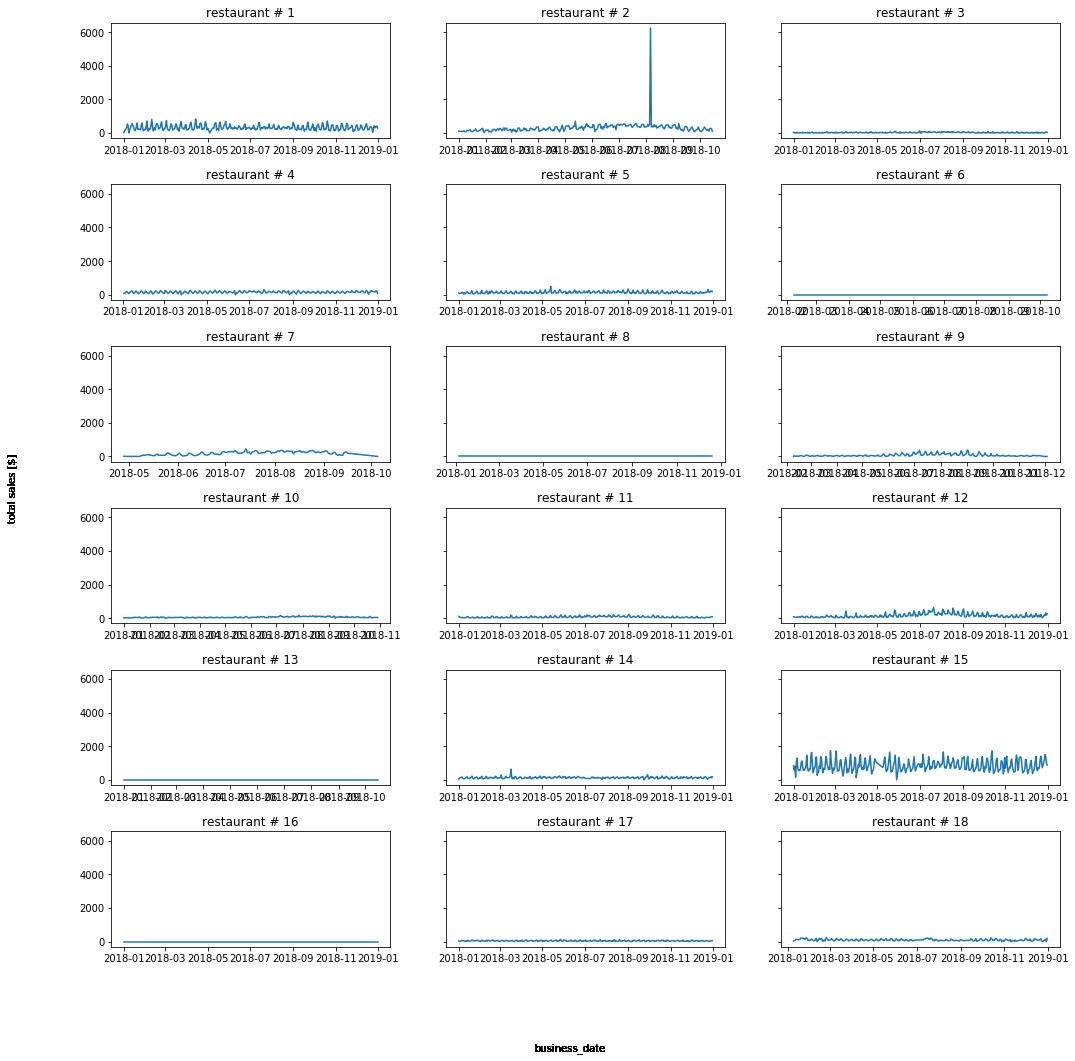

In [46]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(nrows=6, ncols=3,sharey=True, figsize=(17,17) )
fig.subplots_adjust(hspace=0.4)
store_id=0
for row in ax:
    for col in row:
        store_id += 1
        daily_guests=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_guest_count']].groupby('business_date').sum()
        col.plot(daily_guests)
        col.set_title('restaurant # %i' %store_id)
        fig.text(0.5, 0.04, 'business_date', ha='center')
        fig.text(0.04, 0.5, 'total sales [$]', va='center', rotation='vertical')
plt.show()

# SHOULD IMPROVE VISUALIZATION, AT LEAST BY SHORTENING DATE FORMATS TO JAN, FEB, MAR, etc!!


Note:
Restaurants aren't on the same scale w respect to the number of guests.

Restaurants 6,8, 13 and 16 weren't registering number of guests.

Restaurant 14 has a peak at same place where it has peak for sales -- ok!

...COULD also look at how long do guests stay at the restaurant!!
...

...Could also look at average money spent per customer...

DUCK SALES

In [47]:
f=df['item_name'].str.lower().str.contains('duck', na=False)

In [49]:
# Restaurants that have sold duck 
df[f]['store_id'].unique()

array([ 5, 10, 15, 17, 18])

To do: Convert back to the original restaurant id

In [50]:
df[f].groupby('store_id')['item_sales'].sum() #total sales from duck meals, per restaurant

store_id
5      14549.44
10      8356.10
15        76.00
17       406.00
18    183504.60
Name: item_sales, dtype: float64

Sales of duck meals per day of the week in restaurant 5:

In [93]:
duck=df[f]

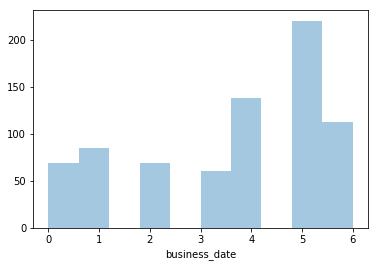

In [110]:
g=sns.distplot(duck[duck['store_id']==5]['business_date'].dt.dayofweek, hist=True, kde=False)

CLUSTERING

An aspect of the type of the restaurant: distribution of money spent per customer, distribution of item prices, distribution of daily sales
plot distribution of sales per day, in dollars, per restaurant (can be one of the measures of similarity between restaurant)


Visually begin to see whether there are some similarities in the restaurants based on the distribution of daily sales:

/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


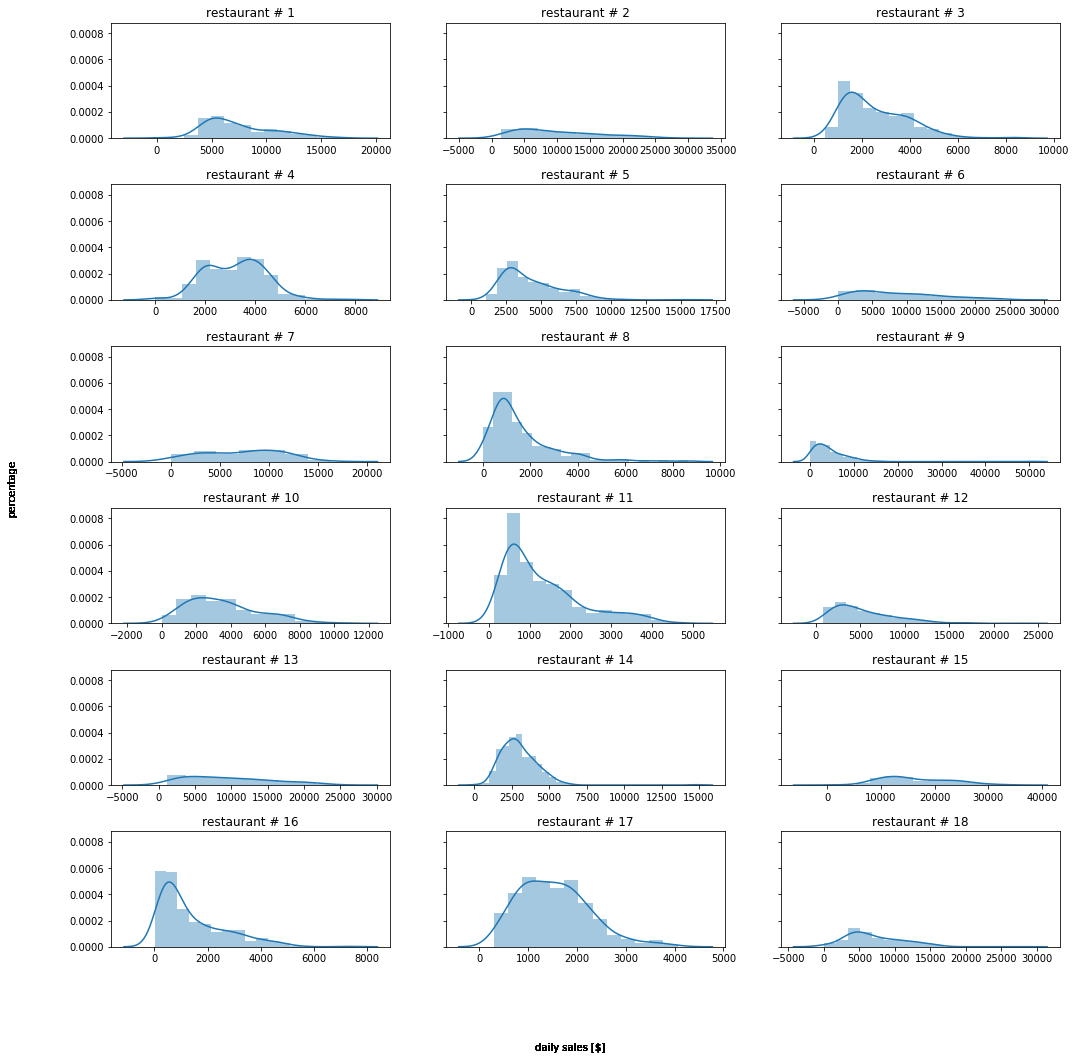

In [51]:
import matplotlib.dates as mdates
fig, ax = plt.subplots(nrows=6, ncols=3, sharey=True, figsize=(17,17) )
fig.subplots_adjust(hspace=0.4)
store_id=0
for row in range(6):
    for col in range(3):
        store_id += 1
        daily_sales=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()
        sns.distplot(daily_sales, ax=ax[row][col])
        ax[row][col].set_title('restaurant # %i' %store_id)
        fig.text(0.5, 0.04, 'daily sales [$]', ha='center')
        fig.text(0.04, 0.5, 'percentage', va='center', rotation='vertical')
plt.show()


# TODO: similar plots for: distribution of money spent per customer, distribution of prices of items sold ...


Hierarchical clustering

In the first pass, look at the similarity between restaurants just based on daily sales
Later on, we should consider also average amount of money a customer spends, average amount of time a customer stays 
in the restaurant, types of food/drinks that are being sold etc.

In [52]:
from scipy.cluster.hierarchy import dendrogram
#H_cluster = linkage(dataset2_standardized,'ward')

# Create dataframe X in which column i corresponds to daily sales of restaurant #i
store_id = 1
X=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()
for store_id in range(2,19):
        daily_sales=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_net_sales']].groupby('business_date').sum()
        X=pd.concat([X,daily_sales], axis=1)
X.columns=['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17','18']


many NaN values because not all restaurants were open every day of the year 2018
we will impute them with value 0

In [53]:
X=X.fillna(0).head()

In [54]:
from sklearn import preprocessing
x_std=preprocessing.scale(X)  #standardize data before clustering
X_std = pd.DataFrame(x_std)

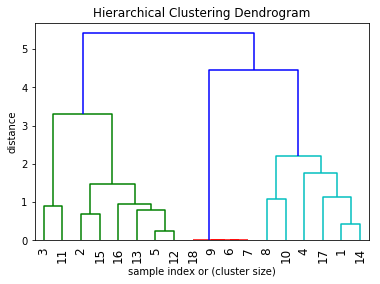

In [78]:
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage
Z = hierarchy.linkage(X_std.T.values, 'ward')
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index or (cluster size)')
plt.ylabel('distance')
hierarchy.dendrogram(
    Z,
    leaf_rotation=90.,
    leaf_font_size=12.,  
    labels = X_std.columns+1
)
plt.show()

K-means clustering : decide the number of clusters based on reduction in variance.
This is just a first pass where I am looking at the similarity between restaurants solely based on daily sales.
Later on, we should consider also average amount of money a customer spends, average amount of time a customer stays 
in the restaurant, types of food/drinks that are being sold etc. 

/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (16). Possibly due to duplicate points in X.
  return_n_iter=True)
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/sklearn/cluster/k_means_.py:971: ConvergenceWarning: Number of distinct clusters (15) found smaller than n_clusters (17). Possibly due to duplicate points in X.
  return_n_iter=True)


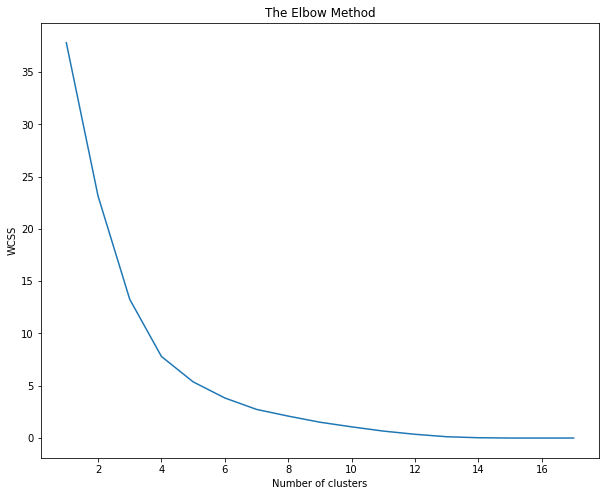

In [56]:
from sklearn.cluster import KMeans
plt.figure(figsize=(10, 8))
wcss = []
for i in range(1, 18):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_std.T.values)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 18), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [57]:
# Fitting K-Means to the dataset

# Select 6 clusters based on the Elbow method

Kmean = KMeans(n_clusters=6)
Kmean.fit(X_std.T.values)
Kmean.labels_

array([3, 0, 4, 5, 0, 2, 2, 1, 2, 1, 4, 0, 0, 3, 0, 0, 3, 2], dtype=int32)

 Groups of restaurants based on this Kmeans algo: {1,14,17}, {6,7,9,18},{2,5,12,13,15,16},{3,11},{8,10},{4}.
We can note some similarity between this result and the dendogram above!

PREDICTIONS

 In the first pass, assume restaurants are independent among them. Later on, we can use  clustering, i.e. information from neighbouring restaurants, to improve predictions

We may want to predict sales of each item in a restaurant (so that restaurant's managers can stock appropriately).

We may want to predict total sales [$] .

Let's assume here that we want to predict daily number of guests for restaurant #1.

In [58]:
store_id = 1
daily_guests1=df[df['store_id']==store_id].groupby(['business_date','ticket_id']).mean()[['ticket_guest_count']].groupby('business_date').sum()

We could try to use a regularized linear regeression model with features: day of the week (dummy variable) for which we are predicting, number of guests at timelag -1, -2 and -3. Would love to use weather data as well but don't have geo location in this dataset.

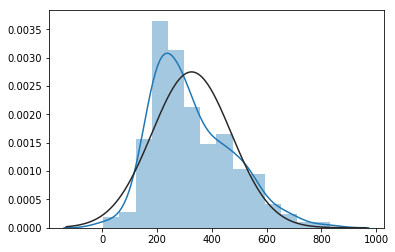

In [123]:
from scipy.stats import norm
from scipy import stats
sns.distplot(daily_guests1, fit=norm)

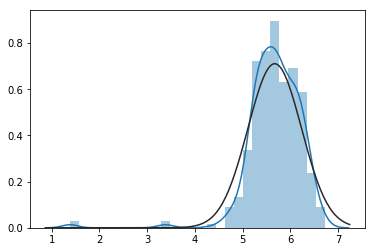

In [126]:
sns.distplot(np.log1p(daily_guests1), fit=norm)

ARIMA model

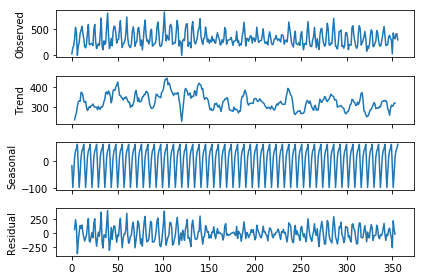

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(pd.Series(daily_guests1['ticket_guest_count'].values), model='additive', freq=7)
fig = result.plot()

/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


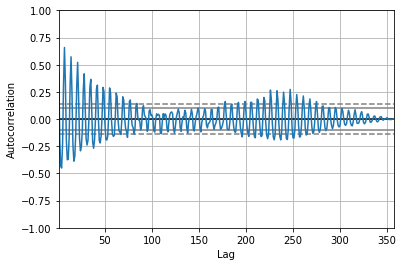

In [61]:
# look at autocorrelation plot to help select parameter p for ARIMA 
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(pd.Series(daily_guests1['ticket_guest_count'].values))

pick parameters of ARIMA based on the lowest mean squared error on the test set.

Let's use the following simplification: as train set use whole timeseries except for the last term and for test set use that last term.

Later on, use less data for train set and more for test set, and leave some data for validation; use sequential prediction approach.

In [62]:
series=pd.Series(daily_guests1['ticket_guest_count'].values)
split_point = len(series) - 1
dataset, test = series[0:split_point], series[split_point:]

In [112]:
# Find the best order for ARIMA based on MSE on the test set

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima_model import ARIMA
p_values = [5,7,9]
d_values = range(0,3)
q_values = range(0,3)
min_error=float("inf")

for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    model = ARIMA(dataset, order)
                    model_fit = model.fit(disp=0)
                    #model_fit.summary();
                    forecast = model_fit.predict()
                    error = mean_squared_error([test.iloc[0]], [forecast.iloc[0]])
                    if error<min_error:
                        min_error = error
                        min_order = order
                except:
                    continue

/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

In [70]:
min_order

(7, 0, 0)

In [71]:
model = ARIMA(dataset, min_order)
model_fit = model.fit(disp=0)
                    #model_fit.summary();
forecast = model_fit.predict()

/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1341: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out_full[ind] += zi
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1344: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out = out_full[ind]
/Users/ivanapetrovic/anaconda3/lib/python3.7/site-packages/scipy/signal/signaltools.py:1350: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. I

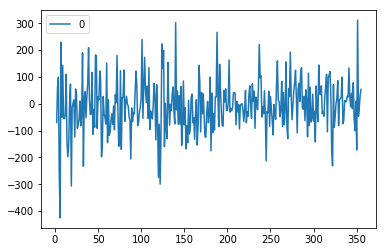

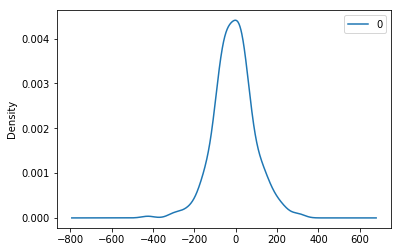

In [114]:
# check residuals
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')